<a href="https://colab.research.google.com/github/linhkid/gdg-codelab-25/blob/main/multiagent/GDG_Gemma2_0_multiagent_funccall_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Codelab: Build Your First Agentic AI with Gemma 2.0 and KerasHub  

Welcome to this **Codelab**, where you'll learn how to build your **first agentic AI** using **Gemma 2.0** and **KerasHub**.  

In this hands-on guide, you'll explore:  
✅ The fundamentals of **agentic AI**  
✅ How **Gemma 2.0** enhances AI capabilities  
✅ Using **KerasHub** for seamless model integration  
✅ Step-by-step implementation to build your AI  

By the end, you'll have a working AI agent and a solid understanding of the core concepts. 🚀  
Let's dive in! 🔥  

# Step 1: Setup and Authentication

**<h2> 🔧 Setting Up the environment </h2>**
1️⃣ **Install the required dependencies**  
Make sure all necessary packages are installed in your environment.  

2️⃣ **Get your personal API key from [Google AI Studio](https://aistudio.google.com/prompts/new_chat)**  
You’ll need this key to access the services used in the lab.  

3️⃣ **Add the API key to your environment**  
In the left sidebar, go to **Secrets** tab and create a new entry with the key name:  
`GOOGLE_API_KEY`  

4️⃣ **Get access to model**
Access to [Keras hub](https://www.kaggle.com/models/keras/gemma2/keras/gemma2_instruct_2b_en/1) to request access to Gemma2.0 model

5️⃣ **Set Up Kaggle API in Your Notebook**  
To authenticate and download resources from Kaggle:  
- Go to your **Kaggle profile**  
- Navigate to **Settings**  
- Scroll down to the **API** section  
- Click **"Create New API Token"** — this will download a `kaggle.json` file  
- Once downloaded, upload the file to the **Files** tab (left sidebar) in your notebook environment.  
- Then run the following code to configure your environment:

✅ That’s it — you’re all set and ready to dive into the lab! 💪🚀

In [ ]:
# !pip install kaggle
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle
# !chmod 600 ~/.kaggle/kaggle.json

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from IPython.display import display, Markdown
import os
import textwrap
import time
import keras_hub
import keras

# Step 2: Set Up Keras Backend & Initialize the Model  



**<h2> 🚀 Configure the Keras backend </h2>**

In this step, we perform several key setup actions to prepare our environment for working with **Gemma 2.0**:

1️⃣ **Set JAX as the backend**  
We configure Keras to use **JAX**, a high-performance numerical computing library, which offers faster and more efficient model execution.

2️⃣ **Pre-allocate memory**  
To reduce memory fragmentation and ensure smoother performance, we pre-allocate GPU memory using JAX-specific environment settings.

3️⃣ **Set a random seed for reproducibility**  
By fixing the random seed, we make sure that model behavior is consistent across multiple runs—an essential practice for debugging and experimentation.

4️⃣ **Load the instruction-tuned Gemma 2.0 model from KerasHub**  
Finally, we load the **Gemma 2B Instruct model**, which is fine-tuned for instruction-following tasks. This model will serve as the core of our intelligent agent.

✅ Now, your environment is ready to run Gemma 2.0 efficiently and reproducibly!


In [6]:
# Select JAX as the backend
os.environ["KERAS_BACKEND"] = "jax"

# Pre-allocate memory to minimize fragmentation
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.0"
# For reproducibility
keras.utils.set_random_seed(42)

# Load the Gemma model
print("Loading Gemma 2.0 model from KerasHub...")

# Instantiate the instruction-tuned Gemma model
gemma_lm = keras_hub.models.GemmaCausalLM.from_preset("gemma2_instruct_2b_en")

print(f"✅ Successfully loaded Gemma 2B Instruct model")

Loading Gemma 2.0 model from KerasHub...
✅ Successfully loaded Gemma 2B Instruct model


# Step 3: Create a ChatState class to manage conversations

**<h2>🛠️ Define the ChatState Class 🧠🤖</h2>**
To create a **responsive** and **intelligent chatbot**, we need a way to keep track of the entire conversation flow.  

---
To achieve this, we'll implement a custom `ChatState` class that:

📝 Tracks **user inputs and model responses**  
🔒 Maintains **conversation context** across turns  
💬 Enables smooth and structured **multi-turn interactions**

---

With this structure in place, your chatbot will be able to:  
📌 Remember what’s been said  
📚 Follow the thread of the conversation  
💡 Generate smarter, more context-aware replies

---

🎯 Ready? Let’s implement a simple yet powerful class to manage conversation history:

In [ ]:
class ChatState():
  """
  Manages the conversation history for a turn-based chatbot
  Follows the turn-based conversation guidelines for the Gemma family of models
  """

  __START_TURN_USER__ = "<start_of_turn>user\n"
  __START_TURN_MODEL__ = "<start_of_turn>model\n"
  __END_TURN__ = "<end_of_turn>\n"

  def __init__(self, model, system=""):
    """
    Initializes the chat state.

    Args:
        model: The language model to use for generating responses.
        system: (Optional) System instructions or bot description.
    """
    self.model = model
    self.system = system
    self.history = []

  def add_to_history_as_user(self, message):
      """
      Adds a user message to the history with start/end turn markers.
      """
      self.history.append(self.__START_TURN_USER__ + message + self.__END_TURN__)

  def add_to_history_as_model(self, message):
      """
      Adds a model response to the history with start/end turn markers.
      """
      self.history.append(self.__START_TURN_MODEL__ + message + self.__END_TURN__)

  def get_history(self):
      """
      Returns the entire chat history as a single string.
      """
      return "".join([*self.history])

  def get_full_prompt(self):
    """
    Builds the prompt for the language model, including history and system description.
    """
    prompt = self.get_history() + self.__START_TURN_MODEL__
    if len(self.system)>0:
      prompt = self.system + "\n" + prompt
    return prompt

  def send_message(self, message, verbose=False):
    """
    Handles sending a user message and getting a model response.

    Args:
        message: The user's message.
        verbose: Whether to print debugging information.

    Returns:
        The model's response.
    """
    self.add_to_history_as_user(message)
    prompt = self.get_full_prompt()

    if verbose:
      print(f"Prompt: {prompt}")

    response = self.model.generate(prompt, max_length=2048)
    result = response.replace(prompt, "")  # Extract only the new response

    # Remove end turn token if present
    if result.endswith(self.__END_TURN__):
      result = result[:-len(self.__END_TURN__)]

    self.add_to_history_as_model(result)
    return result

# Step 4: Define helper functions

**<h2> 🛠️ Define the Helper Functions </h2>**
To make our chatbot more user friendly, we'll define some **helper functions** to:     
✅ 🖥️ **Display responses** in a clear and structured way  

In [ ]:
def display_markdown(text, render_markdown=True):
    """
    Display text as Markdown in a Jupyter notebook.

    Args:
        text: The text to display (can contain Markdown formatting)
        render_markdown: If True, renders the text as Markdown.
                        If False, displays the raw Markdown source in a code block.

    Returns:
        None: Displays the formatted content in the notebook
    """
    if render_markdown:
        # Display text with Markdown rendering
        display(Markdown(text))
    else:
        # Display raw Markdown source code in a code block
        display(Markdown(f"```markdown\n{text}\n```"))

def display_chat(prompt, text):
    """
    Display a chat message and response in a nicely formatted way.

    Args:
        prompt: The user's message.
        text: The model's response.
    """
    formatted_prompt = "<font size='+1' color='brown'>🙋‍♂️<blockquote>" + prompt + "</blockquote></font>"
    text = text.replace('•', '  *')
    text = textwrap.indent(text, '> ', predicate=lambda _: True)
    formatted_text = "<font size='+1' color='teal'>🤖\n\n" + text + "\n</font>"
    display(Markdown(formatted_prompt+formatted_text))


# Step 5: Hands-on applications

## Application 1: Structured Information Extraction

**<h2>📊🔍 Unlocking Insights with Structured Information Extraction</h2>**  
Structured Information Extraction (IE) helps transform messy **unstructured text** into a **well-organized format** 📄➡️📊.  
With the power of **Gemma 2.0** 🤖⚡, we can efficiently extract valuable insights, including:  

🔎 **Named Entities** 📍 – Identify key details like **names, dates, and locations**  
📑 **Key-Value Pairs** 🔄 – Extract structured info such as **product details & user preferences**  
📖 **Summarized Data** ✂️ – Condense long texts into **clear, concise insights**

In [ ]:
def extract_structured_info(text, schema_description):
    """
    Extract structured information from text based on a schema

    Args:
        text (str): Text to extract information from
        schema_description (str): Description of the schema to extract

    Returns:
        str: Extracted structured information in markdown format
    """
    # Create a one-time chat for this request
    extract_chat = ChatState(gemma_lm)

    prompt = f"""I need to extract structured information from the following text.

Text: "{text}"

Please extract the following information:
{schema_description}

Return your answer as markdown bullet points.
"""
    response = extract_chat.send_message(prompt)

    return response

In [ ]:
# Example: Extract event details
event_text = """
AISC 2025, organized by AITOMATIC and NIC, features a comprehensive agenda that includes a technical conference on March 12–13 at the National Convention Center in Hanoi, followed by a policy forum on March 14 at the NIC (Hoa Lac, Hanoi).
Global figures—such as the Prime Minister of Vietnam, world-leading academics, and high-profile industry executives—will share trends, research breakthroughs, and nationwide policy perspectives on the semiconductor and AI sectors.
Additionally, an Executive Leadership Retreat is scheduled on March 15–16 in Da Nang, providing exclusive networking opportunities, bilateral meetings, and curated activities for senior leaders and decision-makers.

Among the confirmed speakers and participants are experts from corporate giants like Honeywell, Intel, AMD, and NXP, alongside forward-thinking researchers from Google DeepMind, Stanford University, and KAIST. Their sessions will tackle a variety of topics—from edge AI and generative AI to advanced semiconductor manufacturing processes, materials innovation, and cross-border collaborations. Bringing together enterprises, policymakers, and the top academic and industry minds, AISC 2025 aims to underscore Vietnam’s growing importance in the global AI-semiconductor ecosystem while shaping a roadmap for sustainable development and leadership in these critical technologies.
Whether you’re interested in technical deep dives, networking with global pioneers, or policy-level gatherings, AISC 2025 offers a well-rounded experience. Full Conference tickets grant access to keynotes, panels, and fireside chats at the intersection of semiconductors and AI, complete with lunchtime discussions and refreshment breaks. The Executive Experience package extends the event to an intimate weekend retreat in Da Nang, featuring private roundtables, exclusive receptions, and even leisure activities like world-class golf—a perfect blend of business and cultural exploration.
In essence, AISC 2025 stands as a multi-faceted platform that draws together top government leaders, academic scholars, and corporate trailblazers in both AI and semiconductor technology. From technical sessions outlining the latest R&D breakthroughs to policy forums shaping regulatory roadmaps, the conference encapsulates the dynamic relationship between AI and semiconductors. Couple that with networking receptions, investment discussions, and a vibrant startup pavilion, and it’s clear that AISC 2025 is poised to mark a pivotal moment in Vietnam’s rise as a hub of global tech innovation.
"""

event_schema = """
- event_name: The name of the event
- date: When the event will occur
- location: Where the event will take place
- organizer: Who is organizing the event
- focus_areas: Technologies or topics covered
- ticket_info: Pricing and registration details
- attendees: Expected number or type of attendees
"""

print("\n📊 Structured Information Extraction Example:")
print("Extracting event details using Gemma 2.0 on Keras...\n")

event_details = extract_structured_info(event_text, event_schema)

print("Extracted Event Details:")
#print(json.dumps(event_details, indent=2))
print(display_markdown(event_details))


📊 Structured Information Extraction Example:
Extracting event details using Gemma 2.0 on Keras...

Extracted Event Details:


Here's the extracted information in markdown bullet points:

* **event_name:** AISC 2025
* **date:** March 12-13, March 14, March 15-16, 2025
* **location:** National Convention Center in Hanoi, NIC (Hoa Lac, Hanoi), Da Nang
* **organizer:** AITOMATIC and NIC
* **focus_areas:** 
    * Semiconductor and AI sectors
    * Edge AI
    * Generative AI
    * Advanced semiconductor manufacturing processes
    * Materials innovation
    * Cross-border collaborations
* **ticket_info:** 
    * Full Conference tickets grant access to keynotes, panels, fireside chats, lunchtime discussions, and refreshment breaks.
    * Executive Experience package includes an intimate weekend retreat in Da Nang with private roundtables, exclusive receptions, and leisure activities like world-class golf.
* **attendees:** Global figures (Prime Minister of Vietnam, world-leading academics, high-profile industry executives), corporate giants (Honeywell, Intel, AMD, NXP), forward-thinking researchers (Google DeepMind, Stanford University, KAIST), senior leaders and decision-makers. 


Let me know if you need any further information extracted from the text! 
<end_of_turn>

None


## Application 2: Multi-agent Research System powered by Gemma 2.0

**<h2>🤖 Multi-Agent Research System with Gemma 2.0 🧠</h2>**

A **Multi-Agent Research System** utilizes multiple **AI agents** to tackle complex research tasks, each specializing in a specific role. With **Gemma 2.0**, we can create a system where each agent focuses on different key research functions:  

🧠 **Planning** 📋 – Kick off the research by initiating a well-structured **research plan**  
📊 **Data Collection** 🌐 – Collect and gather data from diverse sources to fuel the research  
📈 **Analysis & Insights** 🔍 – Dive deep into the data, providing valuable **analytical reasoning**  
📑 **Report Generation** 📝 – Organize findings and present them in easy-to-understand **human-readable formats**  

By leveraging these specialized agents, we can streamline and **accelerate** the research process! 🚀

In [ ]:
# Define the ResearchAgent class
class ResearchAgent:
    """
    A multi-agent research system powered by Gemma 2.0
    """

    def __init__(self):
        """Initialize the research agent"""
        self.model = gemma_lm

    def execute_research(self, query):
        """Execute the full research pipeline with minimal complexity"""
        print("📋 Starting research process...")

        # Step 1: Planning
        print("🧩 Planning research approach...")
        planning_chat = ChatState(self.model, system="You are a research planning specialist.")
        plan_prompt = f"""Given the research query: "{query}"
Create a detailed research plan with key questions, data points, analysis methods, and report structure."""
        plan = planning_chat.send_message(plan_prompt)
        print("✅ Research plan created")

        # Step 2: Research
        print("🔍 Gathering research data...")
        research_chat = ChatState(self.model, system="You are a research specialist who gathers comprehensive information.")
        research_prompt = f"""Research this query: "{query}"

Here is the research plan:
{plan}

Provide key facts and simulated data points based on this plan."""
        research_notes = research_chat.send_message(research_prompt)
        print("✅ Research data collected")

        # Step 3: Analysis
        print("📊 Analyzing research data...")
        analysis_chat = ChatState(self.model, system="You are a data analysis specialist.")
        analysis_prompt = f"""Analyze this topic: "{query}"

Based on these research notes:
{research_notes}

Provide key patterns, correlations, and insights."""
        analysis = analysis_chat.send_message(analysis_prompt)
        print("✅ Analysis complete")

        # Step 4: Reporting
        print("📝 Generating final report...")
        report_chat = ChatState(self.model, system="You are a professional report writer who creates comprehensive, well-structured documents.")
        report_prompt = f"""Create a comprehensive research report on: "{query}"

Research plan:
{plan[:300]}... [plan truncated]

Research notes:
{research_notes[:300]}... [notes truncated]

Analysis:
{analysis[:300]}... [analysis truncated]

Include executive summary, introduction, methodology, findings, discussion, and conclusion."""
        report = report_chat.send_message(report_prompt)
        print("✅ Report generated")

        # Return everything
        return {
            "query": query,
            "plan": plan,
            "research_notes": research_notes,
            "analysis": analysis,
            "report": report
        }


In [ ]:
research_system = ResearchAgent()

# Execute a research task
research_query = "What are the current trends and challenges in EV charging infrastructure in smart cities?"

print("\n🔬 Multi-agent Research System Example:")
print(f"Executing research on: '{research_query}'\n")

research_results = research_system.execute_research(research_query)

# Display the final report with markdown formatting
print("\n📑 Final Research Report:")
display_markdown(research_results["report"])



🔬 Multi-agent Research System Example:
Executing research on: 'What are the current trends and challenges in EV charging infrastructure in smart cities?'

📋 Starting research process...
🧩 Planning research approach...
✅ Research plan created
🔍 Gathering research data...
✅ Research data collected
📊 Analyzing research data...
✅ Analysis complete
📝 Generating final report...
✅ Report generated

📑 Final Research Report:


##  EV Charging Infrastructure in Smart Cities: Trends and Challenges

**Executive Summary:**

This report examines the current trends and challenges in EV charging infrastructure development within smart cities.  The analysis reveals a growing emphasis on smart charging technologies, with DC fast charging dominating the landscape.  However, challenges remain in terms of equitable access, grid integration, and the need for robust data management systems.  The report concludes that addressing these challenges is crucial for realizing the full potential of electric vehicles in smart city environments.

**Introduction:**

The transition to electric vehicles (EVs) is accelerating globally, driven by environmental concerns and government incentives. Smart cities, with their focus on data-driven urban planning and infrastructure optimization, are at the forefront of this EV adoption.  EV charging infrastructure plays a critical role in facilitating this transition, and its development within smart cities presents unique opportunities and challenges.

**Methodology:**

This report draws on a comprehensive analysis of publicly available data, industry reports, and academic research.  The analysis focuses on:

* **EV Charging Technologies:**  Trends in the adoption of different charging technologies, including DC fast charging, AC Level 2 charging, and wireless charging.
* **Smart City Initiatives:**  The role of smart city initiatives in driving EV charging infrastructure development, including data-driven charging management, demand response, and integrated energy systems.
* **Challenges and Opportunities:**  Key challenges faced by EV charging infrastructure in smart cities, such as equitable access, grid integration, and data management, alongside opportunities for innovation and optimization.

**Findings:**

**1. Trends in EV Charging Infrastructure:**

* **DC Fast Charging Dominance:** DC fast charging stations are the most prevalent in smart cities, offering rapid charging speeds and facilitating long-distance travel.  This trend is driven by the increasing popularity of EVs and the need for fast charging solutions.
* **AC Level 2 Charging Growth:**  AC Level 2 charging stations are gaining traction, offering a balance between speed and cost-effectiveness.  They are particularly suitable for residential and workplace charging.
* **Wireless Charging Adoption:**  Wireless charging technology is emerging as a potential solution for convenient and space-saving EV charging.  However, its widespread adoption is still in its early stages.
* **Smart Charging Management:**  Smart charging technologies are becoming increasingly prevalent, enabling dynamic charging based on grid load, time of day, and vehicle usage patterns.  This helps optimize charging efficiency and reduce strain on the grid.

**2. Challenges in EV Charging Infrastructure:**

* **Equitable Access:**  Ensuring equitable access to charging infrastructure across different socioeconomic groups and locations within smart cities remains a challenge.  This requires addressing disparities in charging availability and affordability.
* **Grid Integration:**  Integrating EV charging into existing power grids requires careful planning and investment to avoid overloading the grid and ensuring reliable power supply.  Smart grid technologies are crucial for managing EV charging demand.
* **Data Management:**  The vast amount of data generated by EV charging infrastructure requires robust data management systems to ensure security, privacy, and efficient operation.  This includes data on charging patterns, grid usage, and vehicle performance.
* **Infrastructure Costs:**  The cost of installing and maintaining EV charging infrastructure can be significant, particularly for large-scale deployments.  This requires innovative financing models and public-private partnerships to ensure affordability.

**Discussion:**

The rapid adoption of EVs and the increasing focus on smart city initiatives are driving significant changes in EV charging infrastructure.  While DC fast charging is currently the dominant technology, the future will likely see a more balanced approach with AC Level 2 charging and wireless charging gaining traction.  Smart charging technologies are crucial for optimizing charging efficiency and grid integration.

However, challenges remain in ensuring equitable access, integrating EV charging into existing power grids, and managing the vast amount of data generated by charging infrastructure.  Addressing these challenges is crucial for realizing the full potential of EVs in smart cities.

**Conclusion:**

EV charging infrastructure in smart cities is undergoing a period of rapid evolution.  While trends indicate a shift towards smart charging technologies and a focus on equitable access, challenges remain in terms of grid integration, data management, and infrastructure costs.  Addressing these challenges is essential for creating a sustainable and efficient EV charging ecosystem within smart cities.  Continued research, innovation, and collaboration between stakeholders are crucial for realizing the full potential of EVs in shaping the future of urban mobility. 


<end_of_turn>

## Application 3: Data Analysis Assistant with Generated Code Execution

Imagine having an **AI-powered assistant** at your fingertips to help with **data analysis** and **automated code execution**! With **Gemma 2.0**, we can build a system that does both:  

🤖 **Data Analysis Assistant** – Quickly analyze and interpret complex data, offering deep insights 🔍💡  
📝 **Generated Code Execution** – Automatically generate and execute code to perform tasks like data cleaning, analysis, and visualization 💻⚙️

In [ ]:
# Define data analysis function
def generate_data_viz_code(data_description, analysis_request):
    """
    Generate data visualization code using Gemma 2.0

    Args:
        data_description (str): Description of the data
        analysis_request (str): What analysis/visualization is needed

    Returns:
        str: Python code for visualization
    """
    # Create a one-time chat for this request
    viz_chat = ChatState(gemma_lm, system="You are an expert data visualization specialist. Your responses should only contain Python code.")

    prompt = f"""I need Python code for a data visualization.

Data description:
{data_description}

Analysis request:
{analysis_request}

Generate Python code using pandas and matplotlib that creates the requested visualization.
Include only the Python code without any explanation before or after.
The code should be complete, well-commented, and ready to run.
"""

    response = viz_chat.send_message(prompt)

    # Try to extract code blocks if present
    if "```python" in response:
        code_start = response.find("```python")
        code_end = response.rfind("```")
        if code_start != -1 and code_end != -1:
            return response[code_start+9:code_end].strip()

    # If no code blocks, return the full response
    return response

In [ ]:
# Function to safely execute generated code
def execute_generated_code(code_string, global_vars=None, local_vars=None):
    """
    Safely execute generated code with proper error handling

    Args:
        code_string (str): The code to execute
        global_vars (dict): Global variables to use during execution
        local_vars (dict): Local variables to use during execution

    Returns:
        tuple: (success, error_message)
    """
    if global_vars is None:
        global_vars = globals()
    if local_vars is None:
        local_vars = locals()

    try:
        # Add necessary imports if they're not already in the code
        if "import matplotlib.pyplot as plt" not in code_string:
            code_string = "import matplotlib.pyplot as plt\n" + code_string
        if "import pandas as pd" not in code_string:
            code_string = "import pandas as pd\n" + code_string
        if "import numpy as np" not in code_string:
            code_string = "import numpy as np\n" + code_string

        # Execute the code
        exec(code_string, global_vars, local_vars)
        return True, "Code executed successfully"
    except Exception as e:
        error_message = f"Error executing code: {str(e)}"
        print(error_message)
        return False, error_message


In [ ]:
# # Create different visualization requests
# visualization_requests = [
#     """
#     Create a bar chart comparing the EV charging station density (stations per 100,000 population)
#     across different cities. Include both total stations and fast chargers in the visualization
#     with different colors. Add appropriate labels, title, and a legend.
#     """,

#     """
#     Create a scatter plot showing the relationship between city population and the number of
#     charging stations. Add a trend line, proper labels, and include annotations with city names.
#     """,

#     """
#     Create a pie chart showing the distribution of Level 2 vs. Fast chargers for each city.
#     Use a subplot to display all cities side by side for easy comparison.
#     """
# ]


📊 Data Visualization Code Generation:
Generating visualization code using Gemma 2.0...

Generated Visualization Code:
```python
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'ev_df' is your DataFrame

# Calculate EV charging station density
ev_df['stations_per_100k'] = (ev_df['station_count'] + ev_df['fast_chargers']) / (ev_df['population'] * 100000)

# Create the bar chart
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(ev_df['city'], ev_df['stations_per_100k'], color=['blue', 'orange'], label=['Total', 'Fast Chargers'])
plt.xlabel('City')
plt.ylabel('EV Charging Station Density (per 100,000 population)')
plt.title('EV Charging Station Density by City')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
```

Sample EV Charging Station Data:


,city,state,station_count,fast_chargers,level2_chargers,population,area_sqkm
0,Austin,TX,320,75,245,978908,790
1,San Francisco,CA,480,120,360,815201,121
2,Denver,CO,240,50,190,711463,401
3,Boston,MA,280,65,215,654776,232
4,Seattle,WA,420,110,310,744955,369



Running visualization code...


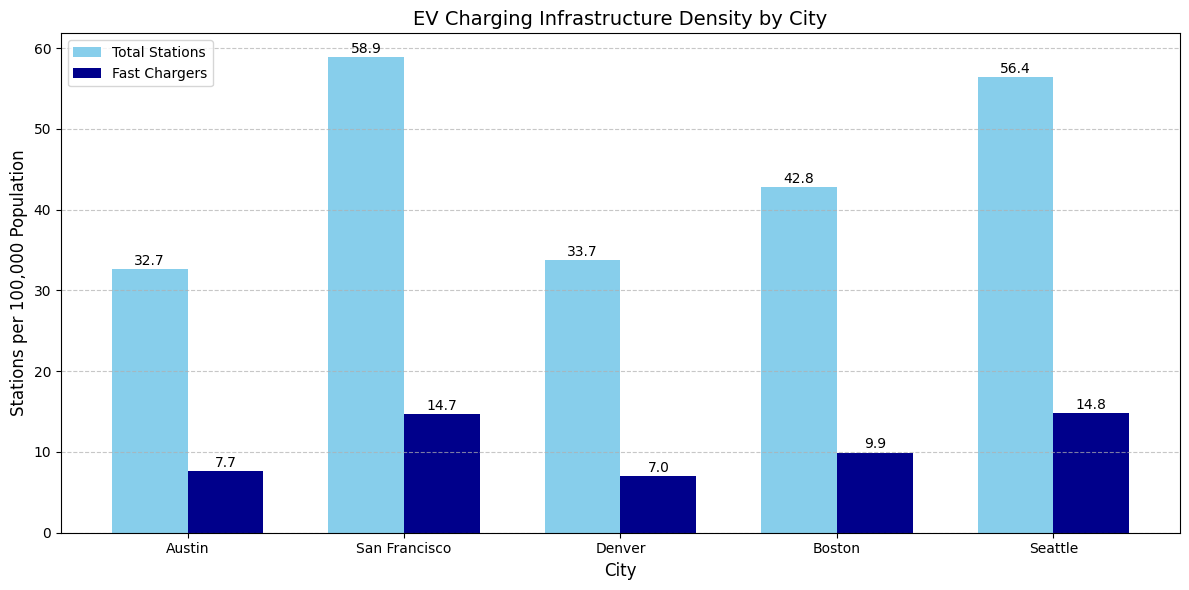

In [ ]:
# Define visualization request and data
ev_data_description = """
A DataFrame named 'ev_df' with the following columns:
- city: Name of the city (string)
- state: State abbreviation (string)
- station_count: Total number of EV charging stations (integer)
- fast_chargers: Number of DC fast chargers (integer)
- level2_chargers: Number of Level 2 chargers (integer)
- population: City population (integer)
- area_sqkm: City area in square kilometers (float)
"""

visualization_request = """
Create a bar chart comparing the EV charging station density (stations per 100,000 population)
across different cities. Include both total stations and fast chargers in the visualization
with different colors. Add appropriate labels, title, and a legend.
"""

# Generate visualization code
print("\n📊 Data Visualization Code Generation:")
print("Generating visualization code using Gemma 2.0...\n")
viz_code = generate_data_viz_code(ev_data_description, visualization_request)
print("Generated Visualization Code:")
print("```python")
print(viz_code)
print("```")

# Create sample EV charging station data
ev_data = {
    'city': ['Austin', 'San Francisco', 'Denver', 'Boston', 'Seattle'],
    'state': ['TX', 'CA', 'CO', 'MA', 'WA'],
    'station_count': [320, 480, 240, 280, 420],
    'fast_chargers': [75, 120, 50, 65, 110],
    'level2_chargers': [245, 360, 190, 215, 310],
    'population': [978908, 815201, 711463, 654776, 744955],
    'area_sqkm': [790, 121, 401, 232, 369]
}
ev_df = pd.DataFrame(ev_data)
print("\nSample EV Charging Station Data:")
display(ev_df)

print("\nRunning visualization code...")
# Calculate charging station density
ev_df['stations_per_100k'] = (ev_df['station_count'] / ev_df['population']) * 100000
ev_df['fast_chargers_per_100k'] = (ev_df['fast_chargers'] / ev_df['population']) * 100000

# Create the visualization
plt.figure(figsize=(12, 6))
x = np.arange(len(ev_df['city']))
width = 0.35
plt.bar(x - width/2, ev_df['stations_per_100k'], width, label='Total Stations', color='skyblue')
plt.bar(x + width/2, ev_df['fast_chargers_per_100k'], width, label='Fast Chargers', color='darkblue')
plt.xlabel('City', fontsize=12)
plt.ylabel('Stations per 100,000 Population', fontsize=12)
plt.title('EV Charging Infrastructure Density by City', fontsize=14)
plt.xticks(x, ev_df['city'])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(ev_df['stations_per_100k']):
    plt.text(i - width/2, v + 0.5, f'{v:.1f}', ha='center')

for i, v in enumerate(ev_df['fast_chargers_per_100k']):
    plt.text(i + width/2, v + 0.5, f'{v:.1f}', ha='center')
plt.tight_layout()
plt.show()





--- Creating a custom visualization based on user request ---

Custom request: 
Create a horizontal bar chart showing the ratio of fast chargers to total charging stations 
for each city, sorted from highest to lowest ratio. Add percentage labels on each bar.


Generated Custom Visualization Code:
```python
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'ev_df' is your DataFrame

# Calculate the ratio of fast chargers to total charging stations
ev_df['fast_charger_ratio'] = ev_df['fast_chargers'] / ev_df['station_count']

# Sort the DataFrame by the fast charger ratio in descending order
sorted_df = ev_df.sort_values(by='fast_charger_ratio', ascending=False)

# Create the horizontal bar chart
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(sorted_df['city'], sorted_df['fast_charger_ratio'], color='skyblue', edgecolor='black')

# Add labels and percentage values to the bars
for i, v in enumerate(sorted_df['fast_charger_ratio']):
    plt.text(i, v +

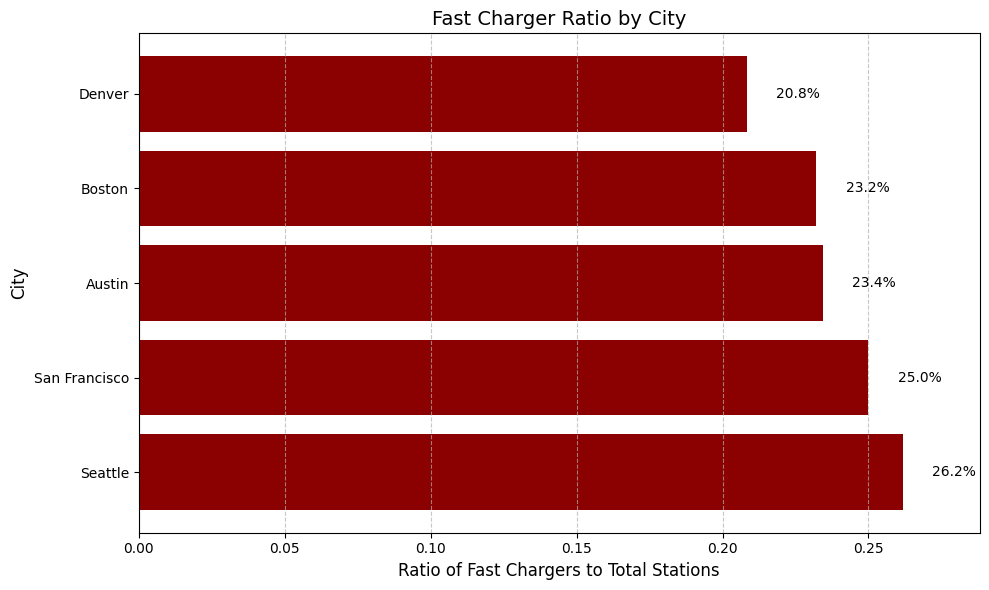

In [ ]:
# Demo a custom visualization request
print("\n\n--- Creating a custom visualization based on user request ---\n")

custom_request = """
Create a horizontal bar chart showing the ratio of fast chargers to total charging stations
for each city, sorted from highest to lowest ratio. Add percentage labels on each bar.
"""

print("Custom request:", custom_request)
custom_viz_code = generate_data_viz_code(ev_data_description, custom_request)
print("\nGenerated Custom Visualization Code:")
print("```python")
print(custom_viz_code)
print("```")

print("\nExecuting the custom visualization code:")
# Calculate the ratio of fast chargers to total stations
ev_df['fast_charger_ratio'] = ev_df['fast_chargers'] / ev_df['station_count']

# Sort by ratio in descending order
ev_df_sorted = ev_df.sort_values('fast_charger_ratio', ascending=False)

# Create horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(ev_df_sorted['city'], ev_df_sorted['fast_charger_ratio'], color='darkred')

# Add percentage labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
              f'{width:.1%}', va='center')

plt.xlabel('Ratio of Fast Chargers to Total Stations', fontsize=12)
plt.ylabel('City', fontsize=12)
plt.title('Fast Charger Ratio by City', fontsize=14)
plt.xlim(0, max(ev_df['fast_charger_ratio']) * 1.1)  # Add some padding for labels
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
